# New York TAXI Fare Prediction

Kaggle competition:

https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview

Based on:

https://jovian.com/aakashns/nyc-taxi-fare-prediction-filled

In [1]:
from pathlib import Path
from dotenv import load_dotenv

RANDOM_STATE = 42
N_JOBS = 4

# Loading Dagshub credentials for MLflow
# load_dotenv()

COMPETITION_NAME = "new-york-city-taxi-fare-prediction"
BASE_PATH = Path(f"../data/{COMPETITION_NAME}")

In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize Kaggle API
api = KaggleApi()
api.authenticate()

# Set your Kaggle API credentials
# os.environ["KAGGLE_USERNAME"] = "your_kaggle_username"
# os.environ["KAGGLE_KEY"] = "your_kaggle_api_key"

# Download the competition data
# api.competition_download_files(COMPETITION_NAME, path="../data", force=True)

In [3]:
import os
import zipfile

# ZIP_FILE = str(BASE_PATH) + ".zip"

# with zipfile.ZipFile(ZIP_FILE, "r") as zip_ref:
#     zip_ref.extractall(BASE_PATH)
    
# os.remove(ZIP_FILE)

## View Dataset Files

In [4]:
# List of files with size
!ls -lh {BASE_PATH}

total 5,4G
-rw-rw-rw-  1 Ariel 0  486 2024-02-08 12:00 GCP-Coupons-Instructions.rtf
-rw-rw-rw-  1 Ariel 0 336K 2024-02-08 12:00 sample_submission.csv
-rw-rw-rw-  1 Ariel 0 960K 2024-02-08 12:00 test.csv
-rw-rw-rw-  1 Ariel 0 906K 2024-02-10 11:23 test_preprocessed.parquet
-rw-rw-rw-  1 Ariel 0 5,4G 2024-02-08 12:00 train.csv
-rw-rw-rw-  1 Ariel 0  38M 2024-02-10 11:23 train_preprocessed.parquet


In [5]:
!head {BASE_PATH}/train.csv

key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.84161,40.712278,1
2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.76127,-73.991242,40.750562,2
2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.98713,40.733143,-73.991567,40.758092,1
2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.73163,-73.972892,40.758233,1
2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.9513,40.774138,-73.990095,40.751048,1
2012-12-03 13:10:00.000000125,9,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.99

In [6]:
!head {BASE_PATH}/test.csv

key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320007324219,40.7638053894043,-73.981430053710938,40.74383544921875,1
2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862182617188,40.719383239746094,-73.998886108398438,40.739200592041016,1
2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.75126,-73.979654,40.746139,1
2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.98116,40.767807,-73.990448,40.751635,1
2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1
2012-12-01 21:12:12.0000005,2012-12-01 21:12:12 UTC,-73.960983,40.765547,-73.979177,40.740053,1
2011-10-06 12:10:20.0000001,2011-10-06 12:10:20 UTC,-73.949013,40.773204,-73.959622,40.770893,1
2011-10-06 12:10:20.0000003,2011-10-06 12:10:20 UTC,-73.777282,40.646636,-73.985083,40.759368,1
2011-10-06 12:10:20.0000002,2011-10-06 12:10:20 UTC,-74.01409

In [7]:
!wc -l {BASE_PATH}/train.csv

55423856 data\new-york-city-taxi-fare-prediction/train.csv


In [8]:
!wc -l {BASE_PATH}/test.csv

9914 data\new-york-city-taxi-fare-prediction/test.csv


In [9]:
!wc -l {BASE_PATH}/sample_submission.csv

9915 data\new-york-city-taxi-fare-prediction/sample_submission.csv


## Loading data

In [10]:
import pandas as pd
import random

In [11]:
header = pd.read_csv(BASE_PATH / "train.csv", nrows=0)
selected_columns = header.columns[1:]
selected_columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [12]:
dtypes = {
    "fare_amount": "float32",
    "pickup_longitude": "float32",
    "pickup_latitude": "float32",
    "dropoff_longitude": "float32",
    "passenger_count": "float32",
}

In [13]:
# 0.1 for 5m rows and 0.01 for 500 000 rows. Less data is more appropriate for EDA and experimentation.
sample_frac = 0.1

train_df = pd.read_csv(
    BASE_PATH / "train.csv",
    usecols=selected_columns,
    dtype=dtypes,
    parse_dates=["pickup_datetime"],
    skiprows=lambda i: i > 0 and random.random() > sample_frac,
)

In [14]:
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.7,2012-04-21 04:30:42+00:00,-73.987129,40.733143,-73.991570,40.758092,1.0
1,16.5,2012-01-04 17:22:00+00:00,-73.951302,40.774139,-73.990097,40.751048,1.0
2,7.0,2013-07-02 19:54:00+00:00,-74.005363,40.728867,-74.008911,40.710907,1.0
3,7.7,2011-04-05 17:11:05+00:00,-74.001823,40.737549,-73.998062,40.722788,2.0
4,12.5,2014-02-19 07:22:00+00:00,-73.986427,40.760464,-73.988991,40.737075,1.0


In [15]:
test_df = pd.read_csv(
    BASE_PATH / "test.csv", dtype=dtypes, parse_dates=["pickup_datetime"]
)
test_df

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1.0
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1.0
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746139,1.0
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751635,1.0
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1.0
...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51+00:00,-73.968124,40.796997,-73.955643,40.780388,6.0
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51+00:00,-73.945511,40.803600,-73.960213,40.776371,6.0
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15+00:00,-73.991600,40.726608,-73.789742,40.647011,6.0
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19+00:00,-73.985573,40.735432,-73.939178,40.801731,6.0


## Exploring data

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5543237 entries, 0 to 5543236
Data columns (total 7 columns):
 #   Column             Dtype              
---  ------             -----              
 0   fare_amount        float32            
 1   pickup_datetime    datetime64[ns, UTC]
 2   pickup_longitude   float32            
 3   pickup_latitude    float32            
 4   dropoff_longitude  float32            
 5   dropoff_latitude   float64            
 6   passenger_count    float32            
dtypes: datetime64[ns, UTC](1), float32(5), float64(1)
memory usage: 190.3 MB


In [18]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                9914 non-null   object             
 1   pickup_datetime    9914 non-null   datetime64[ns, UTC]
 2   pickup_longitude   9914 non-null   float32            
 3   pickup_latitude    9914 non-null   float32            
 4   dropoff_longitude  9914 non-null   float32            
 5   dropoff_latitude   9914 non-null   float64            
 6   passenger_count    9914 non-null   float32            
dtypes: datetime64[ns, UTC](1), float32(4), float64(1), object(1)
memory usage: 387.4+ KB


In [19]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.543237e+06,5.543237e+06,5.543237e+06,5.543194e+06,5.543194e+06,5.543237e+06
mean,1.133463e+01,-7.251934e+01,3.992154e+01,-7.251587e+01,3.992293e+01,1.685389e+00
std,9.736372e+00,1.257021e+01,9.969090e+00,1.261375e+01,9.708972e+00,1.314653e+00
min,-6.200000e+01,-3.370720e+03,-3.475475e+03,-3.395841e+03,-3.475475e+03,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073494e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396707e+01,4.076714e+01,-7.396369e+01,4.076811e+01,2.000000e+00
max,6.685000e+02,3.061945e+03,3.408790e+03,3.442219e+03,3.352849e+03,2.080000e+02


In [20]:
train_df.pickup_datetime.min(), train_df.pickup_datetime.max()

(Timestamp('2009-01-01 00:01:26+0000', tz='UTC'),
 Timestamp('2015-06-30 23:58:44+0000', tz='UTC'))

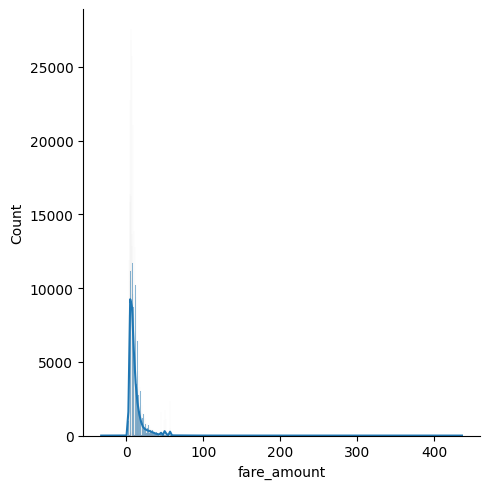

In [22]:
sns.displot(train_df.sample(frac=0.1, random_state=RANDOM_STATE).fare_amount, kde=True)
# plt.xscale("log")
# plt.yscale("log")
plt.show()

In [23]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974716,40.751041,-73.973656,40.751743,1.671273
std,0.042799,0.033542,0.039093,0.035435,1.278756
min,-74.252190,40.573143,-74.263245,40.568973,1.000000
25%,-73.992500,40.736125,-73.991249,40.735254,1.000000
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000
max,-72.986534,41.709557,-72.990967,41.696683,6.000000


In [24]:
test_df.pickup_datetime.min(), test_df.pickup_datetime.max()

(Timestamp('2009-01-01 11:04:24+0000', tz='UTC'),
 Timestamp('2015-06-30 20:03:50+0000', tz='UTC'))

## Outlier removal

In [25]:
from shapely.geometry import Point, Polygon

NYC_BOUNDARY = Polygon(
    [
        (-74.257159, 40.495992),  # South-West
        (-73.699215, 40.495992),  # South-East
        (-73.699215, 40.915568),  # North-East
        (-74.257159, 40.915568),  # North-West
    ]
)

def is_in_new_york(latitude: float, longitude: float) -> bool:
    if latitude is None or longitude is None:
        return False
    
    # Create a Point object for the given coordinates
    point = Point(longitude, latitude)

    # Check if the point is within the New York City boundary polygon
    return point.within(NYC_BOUNDARY)

outlier_mask = (
    train_df.pickup_longitude.between(-180, 180) &
    train_df.pickup_latitude.between(-90, 90) &
    train_df.dropoff_longitude.between(-180, 180) &
    train_df.dropoff_latitude.between(-90, 90) &
    train_df.passenger_count.between(1, 7) &
    train_df.fare_amount.between(1, 1000) & 
    train_df.apply(lambda row: is_in_new_york(row["pickup_latitude"], row["pickup_longitude"]), axis=1) &
    train_df.apply(lambda row: is_in_new_york(row["dropoff_latitude"], row["dropoff_longitude"]), axis=1)
)

# Filter out the outliers from the original dataset
train_df = train_df[outlier_mask]
train_df.describe()

C:\Users\Ariel\AppData\Roaming\Python\Python310\site-packages\shapely\predicates.py:946: RuntimeWarning: invalid value encountered in within
  return lib.within(a, b, **kwargs)


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.400018e+06,5.400018e+06,5.400018e+06,5.400018e+06,5.400018e+06,5.400018e+06
mean,1.128240e+01,-7.397582e+01,4.075076e+01,-7.397468e+01,4.075122e+01,1.691355e+00
std,9.394146e+00,2.018069e+00,2.406386e+00,2.018459e+00,3.071016e-02,1.296329e+00
min,1.000000e+00,-7.425707e+01,4.049629e+01,-7.425666e+01,4.049865e+01,1.000000e+00
25%,6.000000e+00,-7.399229e+01,4.073658e+01,-7.399159e+01,4.073558e+01,1.000000e+00
50%,8.500000e+00,-7.398210e+01,4.075336e+01,-7.398062e+01,4.075384e+01,1.000000e+00
75%,1.250000e+01,-7.396834e+01,4.076752e+01,-7.396545e+01,4.076838e+01,2.000000e+00
max,5.428300e+02,-7.369930e+01,4.091555e+01,-7.369926e+01,4.091555e+01,6.000000e+00


## Feature engineering

In [78]:
import numpy as np
from typing import List, Tuple
from geopy.distance import geodesic


def calculate_distance(latitude_1, longitude_1, latitude_2, longitude_2):
    start_locs = np.column_stack((latitude_1, longitude_1))
    end_locs = np.column_stack((latitude_2, longitude_2))
    return np.array([geodesic(start_loc, end_loc).kilometers for start_loc, end_loc in zip(start_locs, end_locs)])


def add_landmark_dropoff_distance(
    df, landmarks: List[Tuple[str, float, float]]
) -> pd.DataFrame:
    for lm_name, lm_lat, lm_lon in landmarks:
        df.loc[:, lm_name + "_drop_distance"] = calculate_distance(
                np.full(df.shape[0], lm_lat),
                np.full(df.shape[0], lm_lon),
                df["dropoff_latitude"],
                df["dropoff_longitude"],
            )
        
    return df

In [81]:
train_df.loc[:, "distance"] = calculate_distance(
    train_df.pickup_latitude,
    train_df.pickup_longitude,
    train_df.dropoff_latitude,
    train_df.dropoff_longitude,
)

train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance,distance
count,539486.000000,539486.000000,539486.000000,539486.000000,539486.000000,539486.000000,539486.000000,539486.000000,539486.000000,539486.000000,539486.000000,539486.000000
mean,11.257788,-73.975525,40.750919,-73.974739,40.751224,1.688472,20.917661,9.664015,18.467566,4.425178,5.907894,3.291081
std,9.429770,0.213257,0.084167,0.211740,0.030617,1.305947,2.707269,2.595515,3.242156,3.290201,3.464337,3.533206
min,1.000000,-74.255539,40.505722,-74.255737,40.502482,1.000000,0.187993,0.108811,0.274020,0.031216,0.008490,0.000000
25%,6.000000,-73.992241,40.736633,-73.991592,40.735698,1.000000,20.566065,8.340251,16.520401,2.135645,3.589860,1.250154
50%,8.500000,-73.982086,40.753399,-73.980644,40.753865,1.000000,21.216725,9.537375,18.004008,3.700257,5.492908,2.146734
75%,12.500000,-73.968369,40.767605,-73.965492,40.768375,2.000000,21.938533,11.003969,19.818925,5.869895,7.633978,3.886777
max,500.000000,-73.700638,40.914528,-73.700485,40.915366,6.000000,44.335041,43.403377,44.837763,38.536807,31.584750,41.786215


In [29]:
test_df.loc[:, "distance"] = calculate_distance(
    test_df.pickup_latitude,
    test_df.pickup_longitude,
    test_df.dropoff_latitude,
    test_df.dropoff_longitude,
)
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974716,40.751041,-73.973656,40.751743,1.671273,3.436329
std,0.042799,0.033542,0.039093,0.035435,1.278756,3.975532
min,-74.252190,40.573143,-74.263245,40.568973,1.000000,0.000000
25%,-73.992500,40.736125,-73.991249,40.735254,1.000000,1.299312
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000,2.218143
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000,4.045387
max,-72.986534,41.709557,-72.990967,41.696683,6.000000,100.063549


In [30]:
popular_landmarks = [
    ("jfk", 40.6413, -73.7781),
    ("lga", 40.7769, -73.8740),
    ("ewr", 40.6895, -74.1745),
    ("met", 40.7794, -73.9632),
    ("wtc", 40.7126, -74.0099),
]

train_df = add_landmark_dropoff_distance(train_df, popular_landmarks)
test_df = add_landmark_dropoff_distance(test_df, popular_landmarks)

In [31]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
count,5.400018e+06,5.400018e+06,5.400018e+06,5.400018e+06,5.400018e+06,5.400018e+06,5.400018e+06,5.400018e+06,5.400018e+06,5.400018e+06,5.400018e+06,5.400018e+06
mean,1.128240e+01,-7.397582e+01,4.075076e+01,-7.397468e+01,4.075122e+01,1.691355e+00,3.305232e+00,2.091429e+01,9.665386e+00,1.847347e+01,4.431500e+00,5.911103e+00
std,9.394146e+00,2.018069e+00,2.406386e+00,2.018459e+00,3.071016e-02,1.296329e+00,3.552264e+00,2.714464e+00,2.593848e+00,3.252564e+00,3.297370e+00,3.478136e+00
min,1.000000e+00,-7.425707e+01,4.049629e+01,-7.425666e+01,4.049865e+01,1.000000e+00,0.000000e+00,4.085349e-03,4.481799e-02,2.012468e-01,6.106604e-03,5.167768e-04
25%,6.000000e+00,-7.399229e+01,4.073658e+01,-7.399159e+01,4.073558e+01,1.000000e+00,1.254241e+00,2.056155e+01,8.339971e+00,1.651947e+01,2.133718e+00,3.579876e+00
50%,8.500000e+00,-7.398210e+01,4.075336e+01,-7.398062e+01,4.075384e+01,1.000000e+00,2.153907e+00,2.121363e+01,9.541421e+00,1.800402e+01,3.702732e+00,5.491812e+00
75%,1.250000e+01,-7.396834e+01,4.076752e+01,-7.396545e+01,4.076838e+01,2.000000e+00,3.905008e+00,2.193759e+01,1.100894e+01,1.982780e+01,5.884545e+00,7.640197e+00
max,5.428300e+02,-7.369930e+01,4.091555e+01,-7.369926e+01,4.091555e+01,6.000000e+00,4.403825e+01,4.938435e+01,4.383332e+01,4.539226e+01,3.898019e+01,3.272179e+01


In [32]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974716,40.751041,-73.973656,40.751743,1.671273,3.436329,20.953724,9.699383,18.593604,4.514950,6.040697
std,0.042799,0.033542,0.039093,0.035435,1.278756,3.975532,3.306152,3.298627,4.042442,4.021270,4.257637
min,-74.252190,40.573143,-74.263245,40.568973,1.000000,0.000000,0.401777,0.285435,0.285542,0.085581,0.040452
25%,-73.992500,40.736125,-73.991249,40.735254,1.000000,1.299312,20.555381,8.330310,16.564572,2.126570,3.670850
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000,2.218143,21.219899,9.503185,18.069037,3.704138,5.542411
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000,4.045387,21.951915,10.994501,19.927721,5.922940,7.759449
max,-72.986534,41.709557,-72.990967,41.696683,6.000000,100.063549,134.538701,126.151568,149.560247,130.461829,138.735324


In [33]:
train_df.to_parquet(BASE_PATH / "train_preprocessed_5m.parquet", index=False)
test_df.to_parquet(BASE_PATH / "test_preprocessed_5m.parquet", index=False)

## Some EDA

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_parquet(
    BASE_PATH / "train_preprocessed.parquet"
)

Busiest day: 5, value: 82676


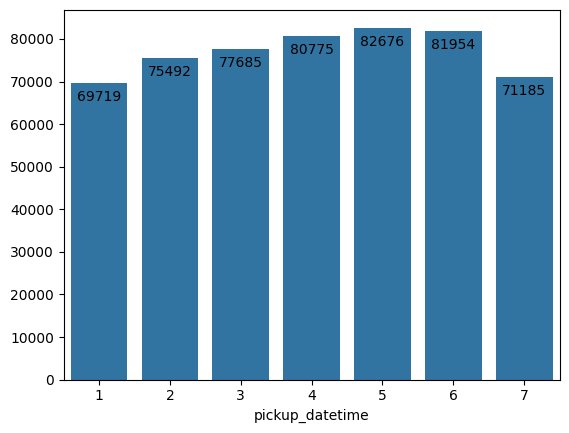

In [12]:
# What is the busiest day of the week?
busiest_day = train_df.pickup_datetime.dt.dayofweek.value_counts().sort_index()

print(f"Busiest day: {busiest_day.idxmax() + 1}, value: {busiest_day.max()}")

sns.barplot(x=busiest_day.index + 1, y=busiest_day.values)
# Add data labels
for i, value in enumerate(busiest_day.values):
    plt.text(i, value - 5000, str(value), ha="center", va="bottom")
plt.show()

Busiest hour: 19, value: 33656


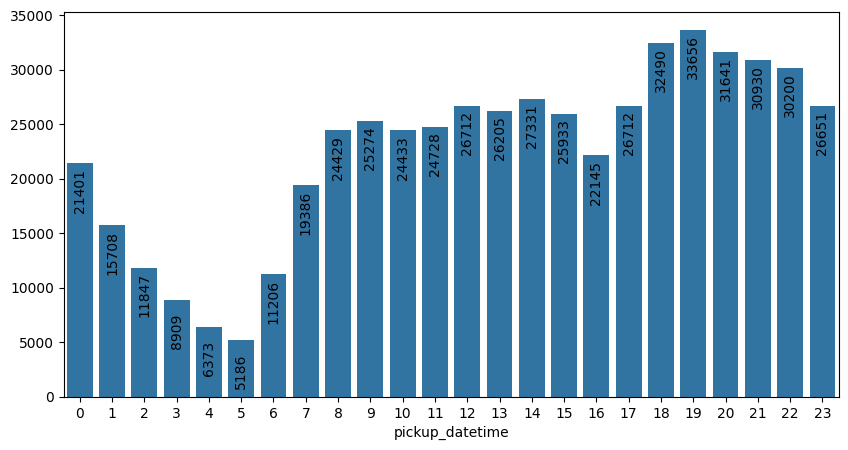

In [33]:
# What is the busiest time of the day?
plt.figure(figsize=(10, 5))
busiest_hour = train_df.pickup_datetime.dt.hour.value_counts().sort_index()
sns.barplot(x=busiest_hour.index, y=busiest_hour.values)

print(f"Busiest hour: {busiest_hour.idxmax()}, value: {busiest_hour.max()}")

for i, value in enumerate(busiest_hour.values):
    plt.text(i, value - 4500, str(value), ha="center", va="bottom", rotation=90)
plt.show()

Highest fare per month: 5, value: 585907.25


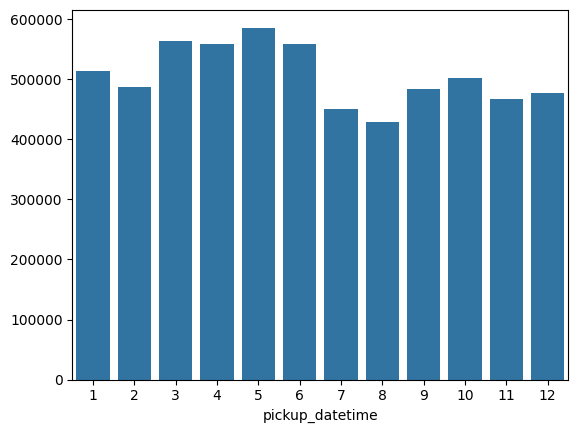

In [38]:
# In which month are fares the highest?
highest_fare_per_month = train_df.groupby(train_df.pickup_datetime.dt.month).fare_amount.sum()
print(f"Highest fare per month: {highest_fare_per_month.idxmax()}, value: {highest_fare_per_month.max()}")

sns.barplot(x=highest_fare_per_month.index, y=highest_fare_per_month.values)
plt.show()


In [39]:
# Which pickup locations have the highest fares?
train_df.groupby(by=["pickup_latitude", "pickup_longitude"]).fare_amount.sum().nlargest(10)

pickup_latitude  pickup_longitude
40.812122        -73.929764          500.000000
40.731655        -73.989174          350.010010
40.759361        -73.936493          212.160004
40.645363        -73.776733          211.700012
40.758282        -73.937874          211.160004
40.769032        -73.862747          200.610001
40.644794        -73.781868          192.239990
40.645332        -73.776726          191.250000
40.645306        -73.776726          188.960007
40.645317        -73.776703          188.630005
Name: fare_amount, dtype: float32

In [87]:
# Which drop locations have the highest fares?
train_df.groupby(by=["dropoff_latitude", "dropoff_longitude"]).fare_amount.sum().nlargest(10)

dropoff_latitude  dropoff_longitude
40.812122         -73.929764           500.000000
40.731696         -73.989212           350.010010
40.690311         -74.177681           186.830002
40.736806         -73.906807           180.330002
40.761200         -73.995811           177.399994
40.774868         -73.977051           170.000000
40.695074         -74.177269           160.899994
40.910181         -74.037880           160.660004
40.746918         -73.826515           158.500000
40.752987         -73.977371           158.250000
Name: fare_amount, dtype: float32

In [40]:
# What is the average ride distance?
train_df["distance"].mean()

3.291081447781088

## Preprocessing

In [3]:
import pandas as pd

In [4]:
train_df = pd.read_parquet(
    BASE_PATH / "train_preprocessed_5m.parquet"
)

test_df = pd.read_parquet(
    BASE_PATH / "test_preprocessed_5m.parquet"
)

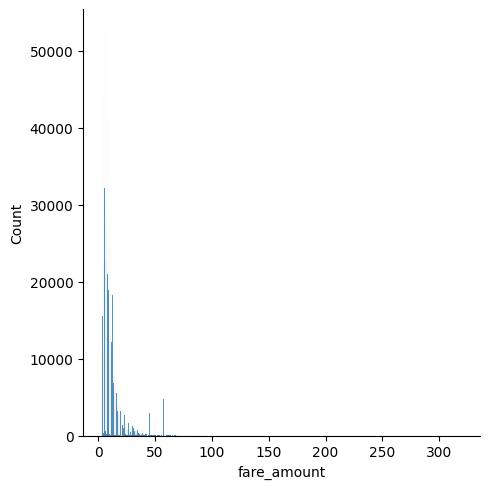

In [81]:
sns.displot(train_df.sample(frac=0.2, random_state=RANDOM_STATE).fare_amount)
plt.show()

In [5]:
train_df = train_df[train_df["fare_amount"] <= 100]

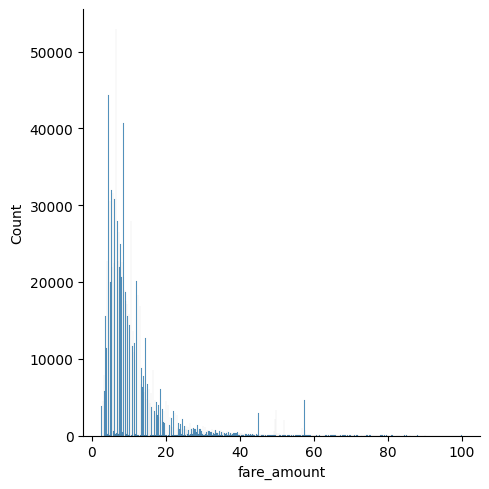

In [107]:
sns.displot(train_df.sample(frac=0.2, random_state=RANDOM_STATE).fare_amount)
plt.show()

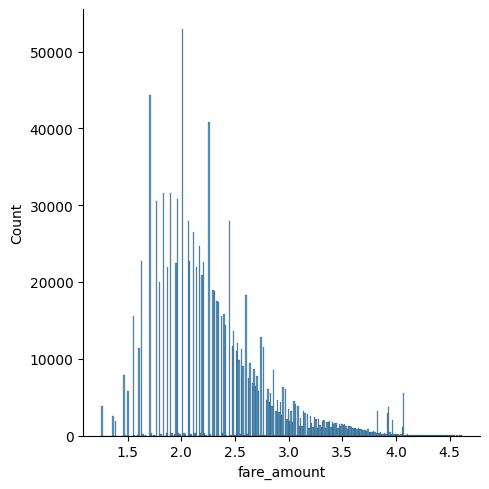

In [108]:
sns.displot(np.log1p(train_df.sample(frac=0.2, random_state=RANDOM_STATE).fare_amount))
plt.show()

In [6]:
selected_columns = train_df.columns
selected_columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'distance',
       'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance',
       'met_drop_distance', 'wtc_drop_distance'],
      dtype='object')

In [7]:
X_train = train_df[selected_columns[1:]].copy()
y_train = train_df[selected_columns[0]].copy()

X_test = test_df[selected_columns[1:]].copy()

X_train.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
0,2012-04-21 04:30:42+00:00,-73.987129,40.733143,-73.991570,40.758092,1.0,2.795843,22.219503,10.143764,17.230059,3.366908,5.283798
1,2012-01-04 17:22:00+00:00,-73.951302,40.774139,-73.990097,40.751048,1.0,4.160058,21.669952,10.214346,17.013425,3.882050,4.585625
2,2013-07-02 19:54:00+00:00,-74.005363,40.728867,-74.008911,40.710907,1.0,2.016783,20.989223,13.547802,14.195247,8.529792,0.205738
3,2011-04-05 17:11:05+00:00,-74.001823,40.737549,-73.998062,40.722788,2.0,1.669683,20.680103,12.078247,15.361757,6.941952,1.510105
4,2014-02-19 07:22:00+00:00,-73.986427,40.760464,-73.988991,40.737075,1.0,2.606302,20.758065,10.669916,16.541644,5.180193,3.241538


In [8]:
from sklearn_ext.utils import DateTransformer
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer

# Identify numeric and categorical columns
numeric_features = make_column_selector(dtype_include="number")

# Create transformers
numeric_transformer = Pipeline(
    steps=[
        # ("imputer", SimpleImputer(strategy="mean")),
        # ("imputer", KNNImputer(n_neighbors=5)),
        ("scaler", StandardScaler()),
        # ("scaler", MinMaxScaler()),
        # ("power_transformer", PowerTransformer()),
        # ("q_transformer", QuantileTransformer(output_distribution="normal")),
    ]
)

# Create a column transformer with passthrough
date_preprocessor = ColumnTransformer(
    transformers=[
        ("date", DateTransformer(["year", "month", "day", "weekday", "hour"]), ["pickup_datetime"])
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
).set_output(transform="pandas")

# Create a column transformer with passthrough
main_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
).set_output(transform="pandas")

# Create a pipeline
preproc_pipeline = Pipeline(steps=[
    ("date_preprocessor", date_preprocessor),
    ("preprocessor", main_preprocessor)
])

# Fit and transform your data
X_train_preproc = preproc_pipeline.fit_transform(X_train)
X_test_preproc = preproc_pipeline.transform(X_test)

y_train_log = np.log1p(y_train)

In [9]:
X_train_preproc.head()

,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
0,0.139598,-0.660418,0.608702,1.005557,-1.460241,-0.337686,-0.659648,-0.501560,0.223931,-0.529153,-0.143136,0.481872,0.185375,-0.382906,-0.322726,-0.180153
1,0.139598,-1.533118,-1.348565,-0.533945,0.534681,0.703571,0.866441,-0.457933,-0.005528,-0.529153,0.241585,0.279168,0.212637,-0.449571,-0.166334,-0.380979
2,0.675628,0.212282,-1.578831,-1.047112,0.841593,-0.867628,-0.818832,-1.015367,-1.313120,-0.529153,-0.362838,0.028079,1.500187,-1.316816,1.244678,-1.640832
3,-0.396432,-0.660418,-1.233431,-1.047112,0.534681,-0.764744,-0.495637,-0.693927,-0.926097,0.236189,-0.460724,-0.085941,0.932570,-0.957844,0.762624,-1.265637
4,1.211659,-1.242218,0.378435,-0.533945,-0.999874,-0.317287,0.357366,-0.425156,-0.460698,-0.529153,-0.196589,-0.057185,0.388602,-0.594754,0.227771,-0.767599


In [10]:
X_test_preproc.head()

,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
0,1.747689,-1.533118,1.299502,-1.047112,-0.079141,0.063650,0.481760,-0.201142,-0.240476,-0.529153,-0.277049,-0.109556,0.047283,-0.332623,-0.058030,-0.485882
1,1.747689,-1.533118,1.299502,-1.047112,-0.079141,-0.329926,-1.171848,-0.718340,-0.391457,-0.529153,-0.248055,0.252717,0.649834,-0.813113,0.290241,-0.809162
2,-0.396432,1.084982,-0.888031,1.005557,-0.386052,-0.203760,0.014717,-0.148473,-0.165438,-0.529153,-0.757303,-0.102950,-0.042925,-0.261737,-0.146855,-0.400791
3,0.139598,1.666782,-1.693965,1.005557,1.148504,-0.164291,0.630719,-0.468331,0.013594,-0.529153,-0.378973,0.301725,0.216624,-0.449842,-0.176971,-0.366551
4,0.139598,1.666782,-1.693965,1.005557,1.148504,0.274961,1.448505,-0.412497,-0.221207,-0.529153,0.586405,0.089881,0.254947,-0.498926,0.001560,-0.558797


In [11]:
from sklearn.model_selection import train_test_split

X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
    X_train_preproc, y_train_log, test_size=0.0185, random_state=RANDOM_STATE
)
X_train_split.shape, X_valid_split.shape, X_test_preproc.shape

((5299259, 16), (99885, 16), (9914, 16))

## Model training

In [12]:
from typing import Callable
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

def get_metrics(model, X_train, y_train, X_valid, y_valid, transform: Callable = np.expm1) -> dict:
    train_rmse = root_mean_squared_error(transform(y_train), transform(model.predict(X_train)))
    valid_rmse = root_mean_squared_error(transform(y_valid), transform(model.predict(X_valid)))
    train_r2 = model.score(X_train, y_train)
    valid_r2 = model.score(X_valid, y_valid)
    return {
        "test_rmse": valid_rmse,
        "train_rmse": train_rmse,
        "test_r2": valid_r2,
        "train_r2": train_r2,
    }

### Baseline model

In [14]:
import joblib

def save_model(model, hyper_params, metrics):
    joblib.dump(
        {
            "model": model,
            "params": hyper_params,
            "metrics": metrics
        }, 
        f"./models/nyc_taxi_{type(model).__name__}.pkl"
    )
    
def load_model(model_name):
    joblib.load(
        f"./models/nyc_taxi_{model_name}.pkl"
    )

In [ ]:
mlflow.set_experiment("NYC-taxi-Linear-regression")

lr_params = dict(
    n_jobs=N_JOBS,
)

lr = LinearRegression(n_jobs=N_JOBS)

with mlflow.start_run(run_name="Linear_Regressor", description="Linear Regressor"):
    mlflow.log_params(lr_params)
    mlflow.set_tag("Training Info", "Linear Regressor")

    lr = LinearRegression(**lr_params)

    lr.fit(X_train_split, y_train_split)

    # Infer the model signature
    # signature = infer_signature(X_train_split, lr.predict(X_train_split))
    
    # Log the model
    # model_info = mlflow.sklearn.log_model(
    #     sk_model=lr,
    #     artifact_path="model",
    #     # signature=signature,
    #     # input_example=X_train_split,
    #     registered_model_name="lr_model",
    # )

    metrics = get_metrics(lr, X_train_split, y_train_split, X_valid_split, y_valid_split)

    mlflow.log_metrics(metrics)

    print(metrics)

lr.score(X_valid_split, y_valid_split)

### Random Forest

In [55]:
mlflow.set_experiment("NYC-taxi-RF-regression")

rf_params = dict(
    # n_estimators=50,
    # max_depth=11,
    # min_samples_split=3,
    min_samples_leaf=4,
    max_features=0.8,
    # max_samples=0.9,
    random_state=RANDOM_STATE, 
    n_jobs=N_JOBS,
    verbose=3
)

with mlflow.start_run(run_name="RF_Regressor", description="Random Forest Regressor"):
    mlflow.log_params(rf_params)
    mlflow.set_tag("Training Info", "Random Forest Regressor")

    rf = RandomForestRegressor(**rf_params)

    rf.fit(X_train_split, y_train_split)

    metrics = get_metrics(rf, X_train_split, y_train_split, X_valid_split, y_valid_split)

    mlflow.log_metrics(metrics)

    print(metrics)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 13.7min


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 56.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   33.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   35.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.6s


{'test_rmse': 3.2641133405043634, 'train_rmse': 2.425145768970014, 'test_r2': 0.8631348053828238, 'train_r2': 0.9418301855719748}


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.8s finished


In [56]:
save_model(rf, rf_params, metrics)

### MLP Regressor

In [43]:
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(
    hidden_layer_sizes=(64, 32), 
    activation="relu",
    solver="adam",
    max_iter=200,
    learning_rate="adaptive", # for SGD only
    learning_rate_init=0.0008,
    alpha=0.00001, # Regulazation L2
    early_stopping=True,
    # tol=1e-4, # Tolerance for the stopping criterion
    # n_iter_no_change=10, # Number of iterations with no improvement
    verbose=3,
    random_state=42
)
nn.fit(X_train_split, y_train_split)

metrics = get_metrics(nn, X_train_split, y_train_split, X_valid_split, y_valid_split)

print(metrics)

Iteration 1, loss = 0.02858191
Validation score: 0.838783
Iteration 2, loss = 0.02312043
Validation score: 0.844839
Iteration 3, loss = 0.02273810
Validation score: 0.846202
Iteration 4, loss = 0.02250876
Validation score: 0.846389
Iteration 5, loss = 0.02233565
Validation score: 0.847366
Iteration 6, loss = 0.02218297
Validation score: 0.850704
Iteration 7, loss = 0.02207420
Validation score: 0.850502
Iteration 8, loss = 0.02199902
Validation score: 0.850927
Iteration 9, loss = 0.02193709
Validation score: 0.849667
Iteration 10, loss = 0.02189263
Validation score: 0.851172
Iteration 11, loss = 0.02184529
Validation score: 0.851304
Iteration 12, loss = 0.02180867
Validation score: 0.851941
Iteration 13, loss = 0.02177208
Validation score: 0.852715
Iteration 14, loss = 0.02173932
Validation score: 0.852751
Iteration 15, loss = 0.02171734
Validation score: 0.852717
Iteration 16, loss = 0.02168538
Validation score: 0.853042
Iteration 17, loss = 0.02167138
Validation score: 0.851747
Iterat

In [44]:
save_model(nn, nn.get_params(), metrics)

### XGB Regressor

In [46]:
from xgboost import XGBRegressor

In [47]:
mlflow.set_experiment("NYC-taxi-XGB-regression")

xgb_params = dict(
    n_estimators=2000,
    learning_rate=0.11,
    # objective="reg:squarederror",
    # booster="gblinear",
    # max_depth=7,
    # subsample=0.999,
    # colsample_bytree=0.999,
    # colsample_bynode=0.999,
    # eval_metric=root_mean_squared_error,
    early_stopping_rounds=100,
    random_state=RANDOM_STATE,
    device="cuda",
    n_jobs=N_JOBS,
)

with mlflow.start_run(run_name="XGB_Regressor", description="XGB Regressor"):
    mlflow.log_params(xgb_params)
    mlflow.set_tag("Training Info", "XGB Regressor")

    xgb = XGBRegressor(**xgb_params)
    xgb.fit(
        X_train_split,
        y_train_split,
        eval_set=[(X_train_split, y_train_split), (X_valid_split, y_valid_split)],
        verbose=True,
    )

    metrics = get_metrics(xgb, X_train_split, y_train_split, X_valid_split, y_valid_split)

    mlflow.log_metrics(metrics)

    print(metrics)

[0]	validation_0-rmse:0.49585	validation_1-rmse:0.49561
[1]	validation_0-rmse:0.45503	validation_1-rmse:0.45483
[2]	validation_0-rmse:0.41962	validation_1-rmse:0.41941
[3]	validation_0-rmse:0.38926	validation_1-rmse:0.38902
[4]	validation_0-rmse:0.36328	validation_1-rmse:0.36301
[5]	validation_0-rmse:0.34127	validation_1-rmse:0.34097
[6]	validation_0-rmse:0.32245	validation_1-rmse:0.32213
[7]	validation_0-rmse:0.30676	validation_1-rmse:0.30640
[8]	validation_0-rmse:0.29361	validation_1-rmse:0.29323
[9]	validation_0-rmse:0.28254	validation_1-rmse:0.28209
[10]	validation_0-rmse:0.27340	validation_1-rmse:0.27297
[11]	validation_0-rmse:0.26565	validation_1-rmse:0.26516
[12]	validation_0-rmse:0.25939	validation_1-rmse:0.25887
[13]	validation_0-rmse:0.25418	validation_1-rmse:0.25361
[14]	validation_0-rmse:0.24969	validation_1-rmse:0.24909
[15]	validation_0-rmse:0.24614	validation_1-rmse:0.24552
[16]	validation_0-rmse:0.24299	validation_1-rmse:0.24231
[17]	validation_0-rmse:0.24026	validation

d:\dev\anaconda3\envs\scikit-learn\lib\site-packages\xgboost\core.py:160: UserWarning: [09:15:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


{'test_rmse': 3.2067041, 'train_rmse': 3.0702069, 'test_r2': 0.8693834637638432, 'train_r2': 0.8776744452879787}


In [59]:
save_model(xgb, xgb_params, metrics)

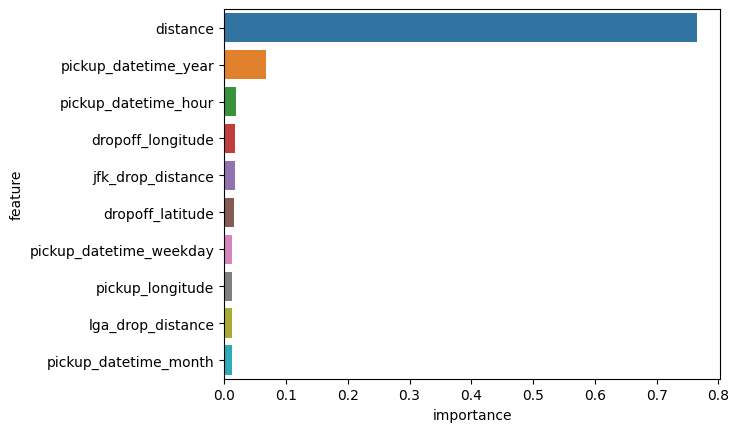

,feature,importance
10,distance,0.764558
0,pickup_datetime_year,0.067771
4,pickup_datetime_hour,0.019664
7,dropoff_longitude,0.017119
11,jfk_drop_distance,0.017108
8,dropoff_latitude,0.015378
3,pickup_datetime_weekday,0.013129
5,pickup_longitude,0.013129
12,lga_drop_distance,0.012800
1,pickup_datetime_month,0.012090


In [117]:
from sklearn_ext.utils import plot_feature_importances

importance_df = plot_feature_importances(X_train_preproc.columns, xgb.feature_importances_, n=10)
importance_df.head(10)

### Catboost

In [49]:
from catboost import CatBoostRegressor

catboost_params = dict(
    iterations=1000, 
    learning_rate=0.18,
    # colsample_bylevel=0.8,
    depth=10,
    # max_depth=10
    early_stopping_rounds=100,
    eval_metric="RMSE",
    task_type="GPU",
    random_seed=RANDOM_STATE,
    # devices="0:1",
)

catboost = CatBoostRegressor(**catboost_params)

catboost.fit(
    X_train_split,
    y_train_split,
    eval_set=[(X_valid_split, y_valid_split)],
    verbose=True,
)

metrics = get_metrics(catboost, X_train_split, y_train_split, X_valid_split, y_valid_split)

print(metrics)

0:	learn: 0.4683467	test: 0.4682119	best: 0.4682119 (0)	total: 146ms	remaining: 2m 25s
1:	learn: 0.4100874	test: 0.4100482	best: 0.4100482 (1)	total: 208ms	remaining: 1m 43s
2:	learn: 0.3648172	test: 0.3647705	best: 0.3647705 (2)	total: 273ms	remaining: 1m 30s
3:	learn: 0.3303279	test: 0.3302548	best: 0.3302548 (3)	total: 332ms	remaining: 1m 22s
4:	learn: 0.3042423	test: 0.3039806	best: 0.3039806 (4)	total: 394ms	remaining: 1m 18s
5:	learn: 0.2846950	test: 0.2843470	best: 0.2843470 (5)	total: 453ms	remaining: 1m 14s
6:	learn: 0.2703214	test: 0.2699621	best: 0.2699621 (6)	total: 513ms	remaining: 1m 12s
7:	learn: 0.2594879	test: 0.2589665	best: 0.2589665 (7)	total: 575ms	remaining: 1m 11s
8:	learn: 0.2515767	test: 0.2509031	best: 0.2509031 (8)	total: 638ms	remaining: 1m 10s
9:	learn: 0.2454723	test: 0.2448043	best: 0.2448043 (9)	total: 699ms	remaining: 1m 9s
10:	learn: 0.2409485	test: 0.2402017	best: 0.2402017 (10)	total: 758ms	remaining: 1m 8s
11:	learn: 0.2376551	test: 0.2368872	best: 

In [58]:
save_model(catboost, catboost_params, metrics)

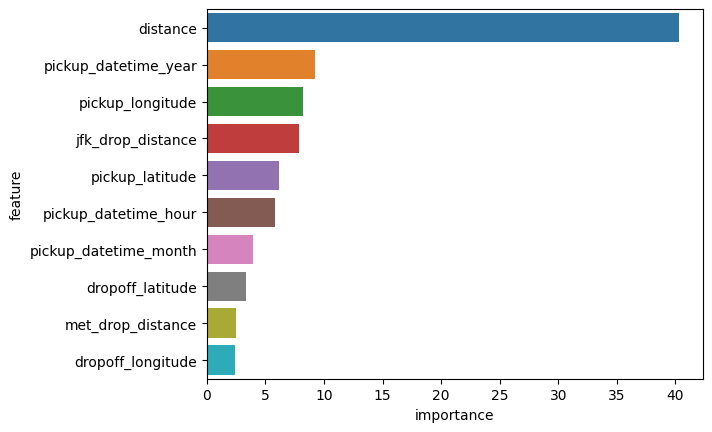

,feature,importance
10,distance,40.337110
0,pickup_datetime_year,9.259498
5,pickup_longitude,8.224737
11,jfk_drop_distance,7.835502
6,pickup_latitude,6.132515
4,pickup_datetime_hour,5.855159
1,pickup_datetime_month,3.925121
8,dropoff_latitude,3.372454
14,met_drop_distance,2.483488
7,dropoff_longitude,2.432793


In [119]:
importance_df = plot_feature_importances(X_train_preproc.columns, catboost.feature_importances_, n=10)
importance_df.head(10)

### LightGBM

In [141]:
from lightgbm import LGBMRegressor

lgbr = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.18,
    force_col_wise=True,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
)

lgbr.fit(X_train_split, y_train_split)

lgbr.fit(
    X_train_split,
    y_train_split,
    eval_set=[(X_valid_split, y_valid_split)],
)

metrics = get_metrics(lgbr, X_train_split, y_train_split, X_valid_split, y_valid_split)

print(metrics)

[LightGBM] [Info] Total Bins 2643
[LightGBM] [Info] Number of data points in the train set: 5299259, number of used features: 16
[LightGBM] [Info] Start training from score 2.331216
[LightGBM] [Info] Total Bins 2643
[LightGBM] [Info] Number of data points in the train set: 5299259, number of used features: 16
[LightGBM] [Info] Start training from score 2.331216
{'test_rmse': 3.2177334486468445, 'train_rmse': 3.1385925316042234, 'test_r2': 0.8681576280069273, 'train_r2': 0.8737722007377684}


### Manual Voting Regression

In [147]:
xgb_preds = np.expm1(xgb.predict(X_test_preproc))
cat_preds = np.expm1(catboost.predict(X_test_preproc))
lgbr_preds = np.expm1(lgbr.predict(X_test_preproc))
rf_preds = np.expm1(rf.predict(X_test_preproc))

test_preds = np.average([xgb_preds, cat_preds, lgbr_preds, rf_preds], axis=0, weights=[1.5, 1.5, 1.1, 0.9])

sub_df = pd.read_csv(BASE_PATH / "sample_submission.csv")
sub_df["fare_amount"] = test_preds
sub_df.to_csv("submission.csv", index=None)
print(api.competition_submit("submission.csv", f"Stacking", COMPETITION_NAME))



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
100%|██████████| 463k/463k [00:01<00:00, 315kB/s]  


Successfully submitted to New York City Taxi Fare Prediction


In [ ]:
from sklearn.ensemble import VotingRegressor

vr = VotingRegressor(
    estimators=[
        ("xgb", xgb),
        ("catboost", catboost),
        ("rf", rf),
    ],
    weights=[1, 1, 1],
    n_jobs=N_JOBS,
)
vr.fit(X_train_split, y_train_split)

### Bagging

In [100]:
from sklearn.ensemble import BaggingRegressor

xgb_params = dict(
    n_estimators=2000,
    learning_rate=0.11,
    # objective="reg:squarederror",
    # booster="gblinear",
    # max_depth=7,
    # subsample=0.999,
    # colsample_bytree=0.999,
    # colsample_bynode=0.999,
    # eval_metric=root_mean_squared_error,
    # early_stopping_rounds=100,
    random_state=RANDOM_STATE,
    device="cuda",
    n_jobs=N_JOBS,
)

base_classifier = XGBRegressor(**xgb_params)

# Create a BaggingClassifier
bagging_model = BaggingRegressor(
    base_classifier, n_estimators=3, verbose=3, random_state=RANDOM_STATE, n_jobs=N_JOBS
)

# Fit and predict
bagging_model.fit(X_train_split, y_train_split)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  2.6min finished


BaggingRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None, device='cuda',
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,
                                        gamma=None, grow_policy=None,
                                        importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=0.11, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        multi_strategy=None, n_estimators=2000,
                                        n_jobs=4, num_parallel_tree=None,
                                        random_state=42, ...),
                 n_estimators=3, n_jobs=4, random_state=42, verbose=3)

In [101]:
bagging_model.score(X_valid_split, y_valid_split)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.6s finished


0.8690910317043534

## Kaggle Submission

In [97]:
def predict_and_submit(
    model,
    X_test,
    file_name="submission.csv",
    hyper_params={},
    transform: Callable = np.expm1,
):
    test_preds = transform(model.predict(X_test))
    sub_df = pd.read_csv(BASE_PATH / "sample_submission.csv")
    sub_df["fare_amount"] = test_preds
    sub_df.to_csv(file_name, index=None)
    print(api.competition_submit(file_name, f"{type(model)}\n{hyper_params}", COMPETITION_NAME))
    print(hyper_params)

    return sub_df

In [102]:
predict_and_submit(catboost, X_test_preproc, hyper_params=catboost_params)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
100%|██████████| 379k/379k [00:01<00:00, 284kB/s]  


Successfully submitted to New York City Taxi Fare Prediction
{'n_estimators': 2000, 'learning_rate': 0.11, 'random_state': 42, 'device': 'cuda', 'n_jobs': 4}


,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.481088
1,2015-01-27 13:08:24.0000003,10.631994
2,2011-10-08 11:53:44.0000002,4.182631
3,2012-12-01 21:12:12.0000002,9.153516
4,2012-12-01 21:12:12.0000003,16.060881
...,...,...
9909,2015-05-10 12:37:51.0000002,9.379008
9910,2015-01-12 17:05:51.0000001,10.615150
9911,2015-04-19 20:44:15.0000001,52.273464
9912,2015-01-31 01:05:19.0000005,18.327316
